In [1]:
import matplotlib.pyplot as plt
import numpy as np
from toolbox import IsoForceRAW, Protocol, generate_DF, scale_to_range

In [33]:
file_path = "../measurements/P04"

In [34]:
iso_raw_DF = generate_DF(file_path)

Cleaned data saved to ../measurements/P04/iso_raw_data.csv


In [35]:
protocol = Protocol(file_path)

../measurements/P04/Participant_P04_protocol.json
{'participant': {'Number': 'P04', 'age': '20', 'gender': 'female', 'leg': 'right'}, 'isokinetic_measurement': {'rotation_velocity': '30 °/s', 'force_levels': '[30 30 20 20 70 70 80 80 50 50 40 40 60 60]'}, 'eit_measurement': {'excitation_frequency': 125000, 'burst_count': 0, 'amplitude': '1 mA', 'frame_rate': 40, 'n_el': 16, 'injection_skip': 5}, 'notes': 'Lever Arm: 28.4 cm'}


In [36]:
protocol.Participant.leg

'right'

## Plot the Torque , Speed, Angle from isoforce DF

Applying low-pass filter to torque and angle data.


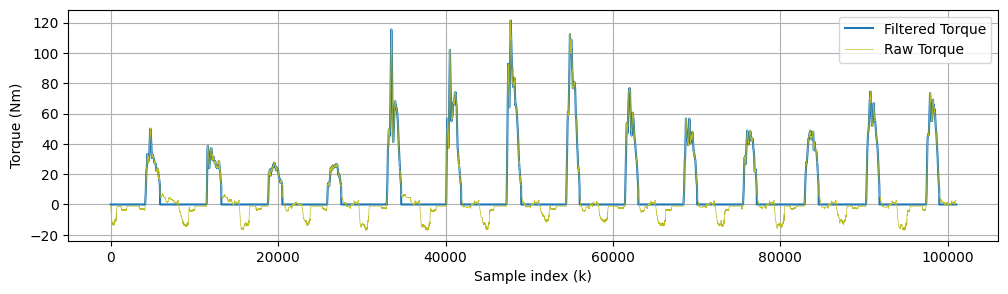

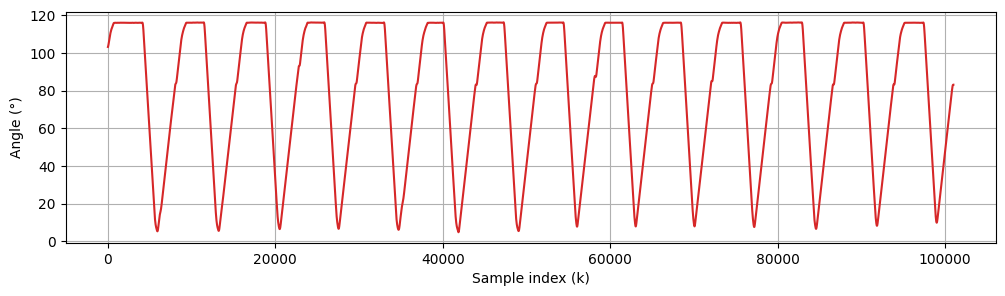

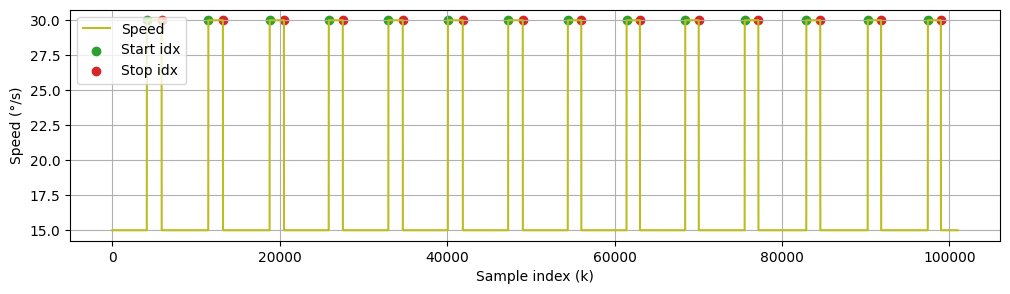

In [37]:
import pandas as pd

# iso_raw_DF = r"D:\EIT\EIT_Thigh_Force_Measurement\GUI_Data_Acquisition\measurements\Judi_t_20250207_084859\iso_raw_data.csv"
# iso_raw_DF = pd.read_csv(iso_raw_DF)
isoforce_iso = IsoForceRAW(iso_raw_DF, protocol, LP_filter_enabled=True)
isoforce_iso.plot_torque()
isoforce_iso.plot_angle()
isoforce_iso.plot_speed()

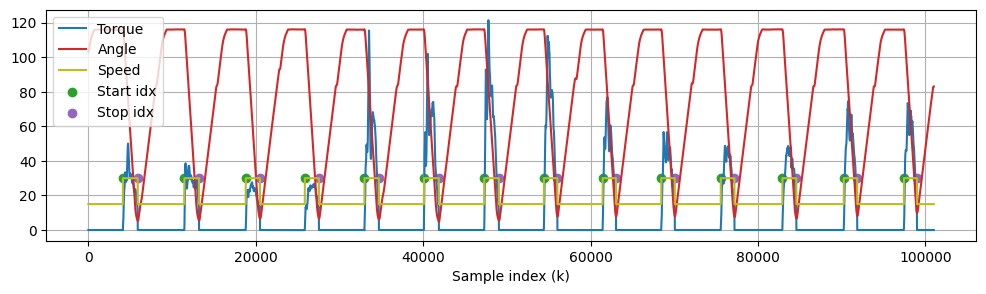

In [38]:
isoforce_iso.plot_data()

## Plot segmented Torque and angle from isoforce DF

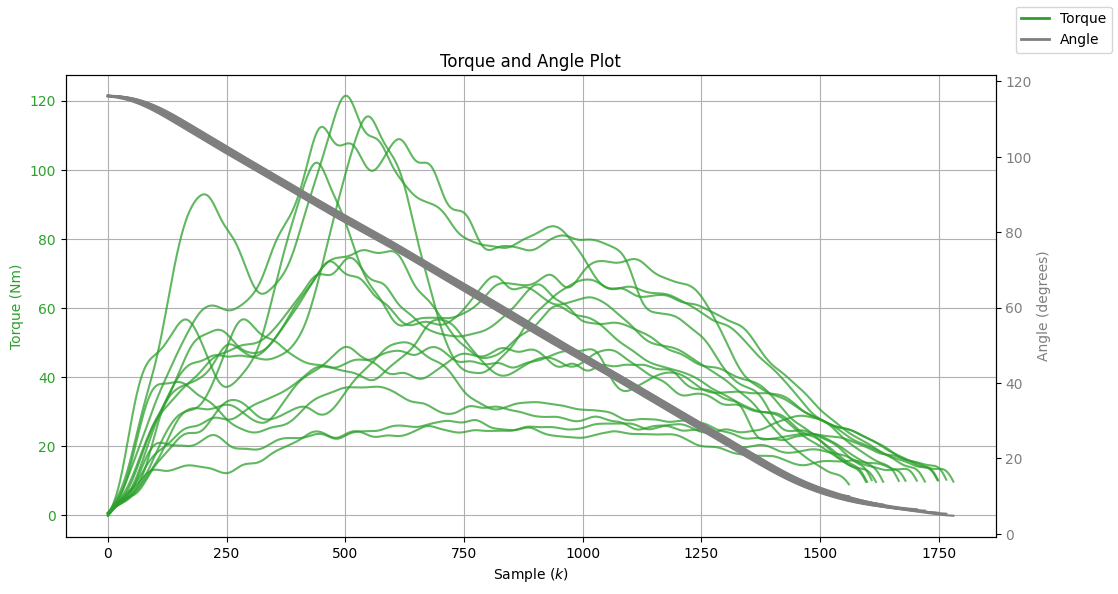

In [39]:
from matplotlib.lines import Line2D

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Torque on the primary y-axis
for idx in range(len(isoforce_iso.torque_segments.keys())):
    ax1.plot(isoforce_iso.torque_segments[f"T_seg_{idx}"], "C2", alpha=0.75)

ax1.set_xlabel("Sample ($k$)")
ax1.set_ylabel("Torque (Nm)", color="C2")
ax1.tick_params(axis="y", labelcolor="C2")
ax1.grid()

# Create a second y-axis for Angle
ax2 = ax1.twinx()
for idx in range(len(isoforce_iso.angle_segments.keys())):
    ax2.plot(isoforce_iso.angle_segments[f"A_seg_{idx}"], "C7")

ax2.set_ylabel("Angle (degrees)", color="C7")
ax2.tick_params(axis="y", labelcolor="C7")

custom_lines = [
    Line2D([0], [0], color="C2", lw=2, label="Torque"),
    Line2D([0], [0], color="C7", lw=2, label="Angle"),
]
fig.legend(handles=custom_lines, loc="upper right")


plt.title("Torque and Angle Plot")
plt.show()

# Isoforce Data Acquisition from NI Chip

The NI chip is equipped with three channels: P, T, and S. Each channel is associated with specific measurement parameters, including a factor and offset, as detailed below:

- **Channel 1 (P):** Angle  
  - Factor: 54  
  - Offset: 12  

- **Channel 2 (T):** Torque  
  - Factor: 150  
  - Offset: 25  

- **Channel 3 (S):** Speed  
  - Factor: 108  
  - Offset: -3  


In [40]:
import os

from toolbox import IsoForcePy

## the distace of peak detection was decreased to 400 to extract all torque segements

In [41]:
isoforce_py = IsoForcePy(
    file_path,
    protocol,
    LP_filter_enabled=True,
    over_UTC=True,
    scale_0_1=True,
    distance=400,
)

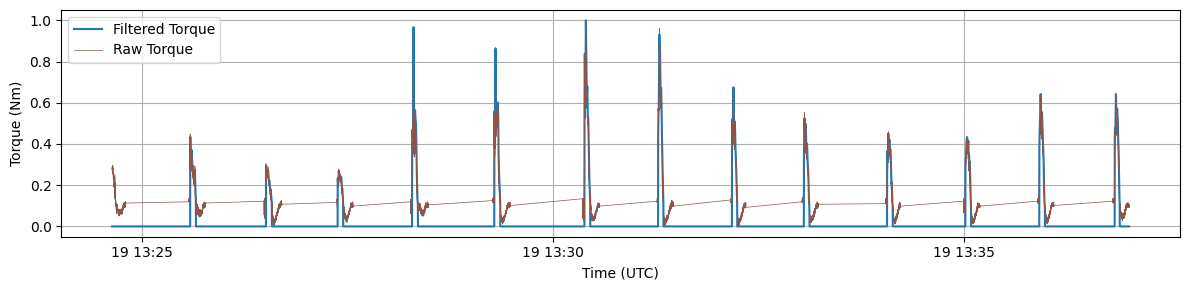

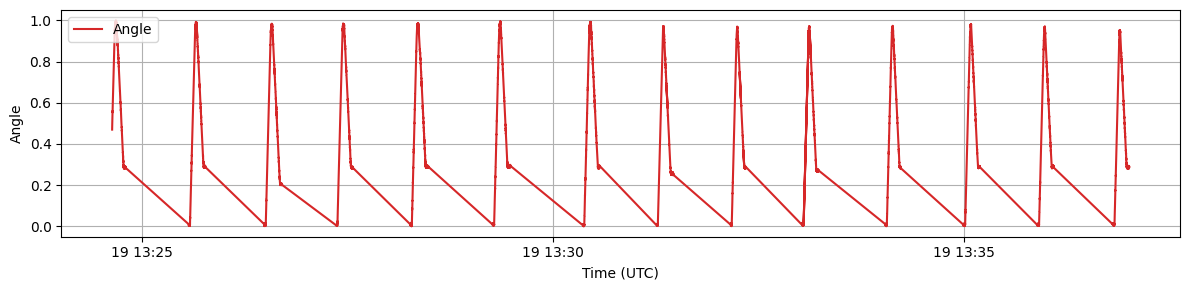

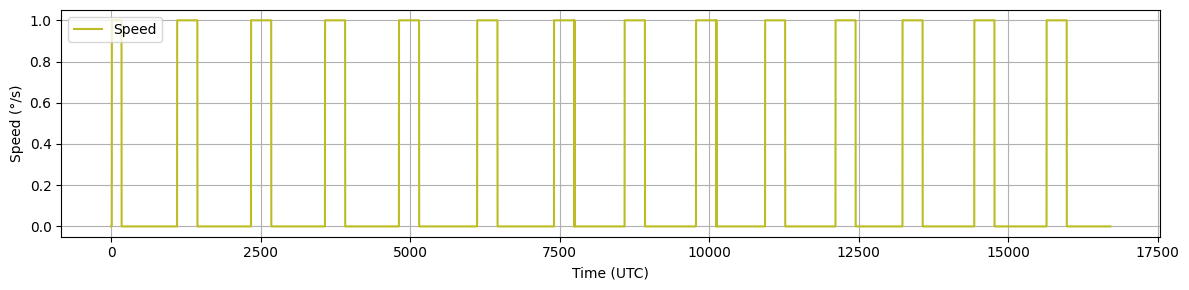

In [42]:
isoforce_py.plot_torque()
isoforce_py.plot_angle()
isoforce_py.plot_speed()

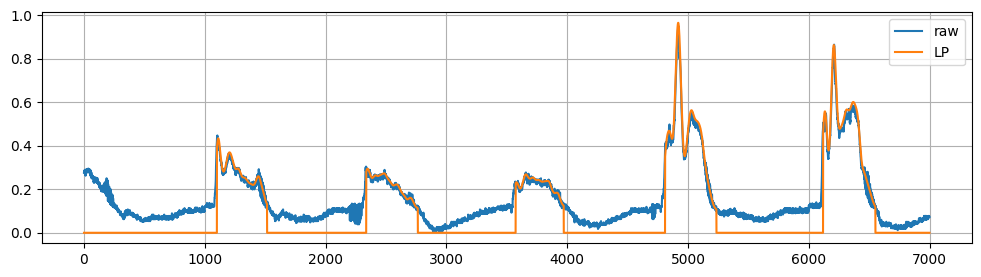

In [43]:
plt.figure(figsize=(12, 3))
plt.plot((isoforce_py.torque_raw[:7000]), label="raw")
plt.plot((isoforce_py.torque[:7000]), label="LP")
plt.legend()
plt.grid()

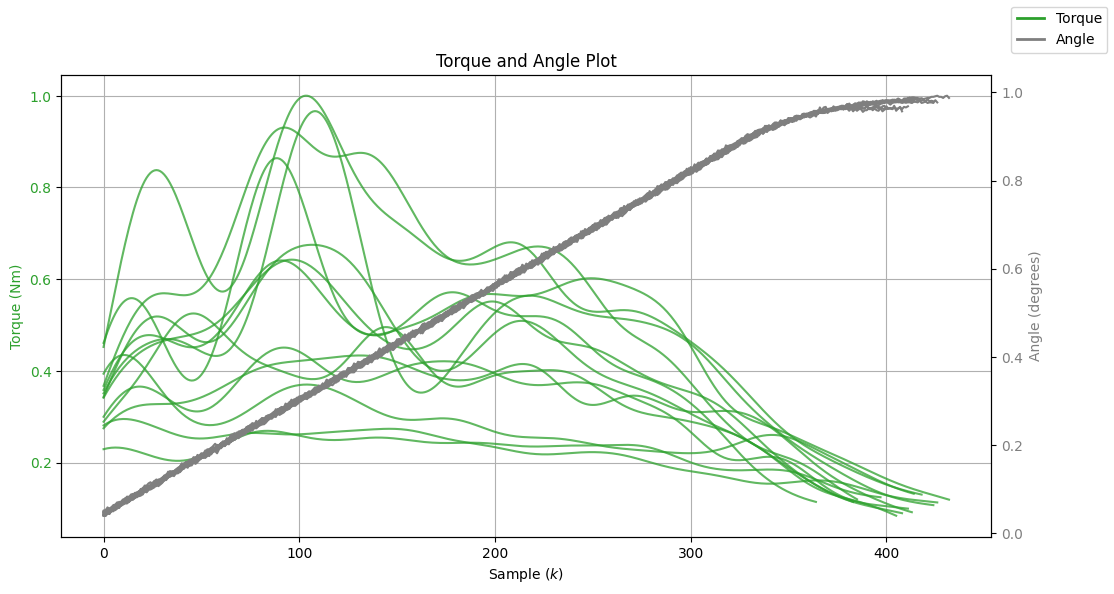

In [44]:
from matplotlib.lines import Line2D

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Torque on the primary y-axis
for idx in range(len(isoforce_py.torque_segments.keys())):
    ax1.plot(isoforce_py.torque_segments[f"T_seg_{idx}"], "C2", alpha=0.75)

ax1.set_xlabel("Sample ($k$)")
ax1.set_ylabel("Torque (Nm)", color="C2")
ax1.tick_params(axis="y", labelcolor="C2")
ax1.grid()

# Create a second y-axis for Angle
ax2 = ax1.twinx()
for idx in range(len(isoforce_py.angle_segments.keys())):
    ax2.plot(isoforce_py.angle_segments[f"A_seg_{idx}"], "C7")

ax2.set_ylabel("Angle (degrees)", color="C7")
ax2.tick_params(axis="y", labelcolor="C7")

custom_lines = [
    Line2D([0], [0], color="C2", lw=2, label="Torque"),
    Line2D([0], [0], color="C7", lw=2, label="Angle"),
]
fig.legend(handles=custom_lines, loc="upper right")


plt.title("Torque and Angle Plot")
plt.show()

## Synchronization between `IsoForceRaw` and `IsoForcePy`

In [45]:
# isoforce_iso.torque_segments.pop(next(iter(isoforce_iso.torque_segments)))
len(isoforce_iso.torque_segments.keys()), len(isoforce_py.torque_segments.keys())

(14, 13)

In [46]:
from scipy.signal import resample


def resample_signals(iso_iso, iso_py, target_length=None):
    iso_iso = np.asarray(iso_iso)
    iso_py = np.asarray(iso_py)
    if target_length:
        print(f"Resample both signals to a length of {target_length} samples.")
        iso_py = resample(iso_py, num=target_length)
        iso_iso = resample(iso_iso, num=target_length)
        return iso_iso, iso_py
    else:
        target_length = max(len(iso_iso), len(iso_py))
        print(f"Resample both signals to a length of {target_length} samples.")
        if len(iso_iso) > len(iso_py):
            iso_py = resample(iso_py, num=target_length)
        elif len(iso_py) > len(iso_iso):
            iso_iso = resample(iso_iso, num=target_length)
        return iso_iso, iso_py


def detect_shift(signal1, signal2):
    N = max(len(signal1), len(signal2))
    corr = np.correlate(signal1, signal2, mode="full")
    lags = np.arange(-N + 1, N)

    max_corr_idx = np.argmax(corr)
    discrete_time_shift = lags[max_corr_idx]
    print(f"Discrete time shift of {discrete_time_shift}.")
    return discrete_time_shift

Resample both signals to a length of 1748 samples.
Discrete time shift of 66.


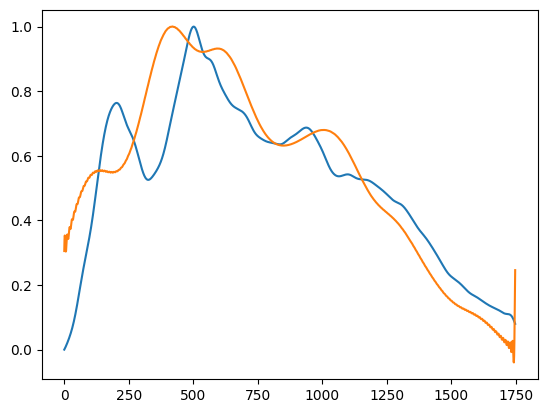

In [47]:
iso_seg_1 = scale_to_range(isoforce_iso.torque_segments[f"T_seg_{6}"])
py_seg_1 = scale_to_range(isoforce_py.torque_segments[f"T_seg_{6}"])
iso_seg_corr, py_seg_corr = resample_signals(iso_seg_1, py_seg_1)

plt.plot(iso_seg_corr, label="iso")
plt.plot(py_seg_corr, label="py")

shift = detect_shift(iso_seg_corr, py_seg_corr)

Resample both signals to a length of 1750 samples.
Discrete time shift of 67.
Resample both signals to a length of 1500 samples.


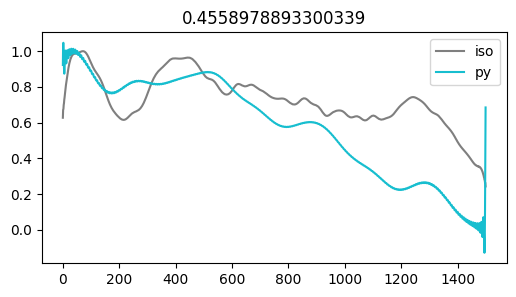

Resample both signals to a length of 1705 samples.
Discrete time shift of 76.
Resample both signals to a length of 1500 samples.


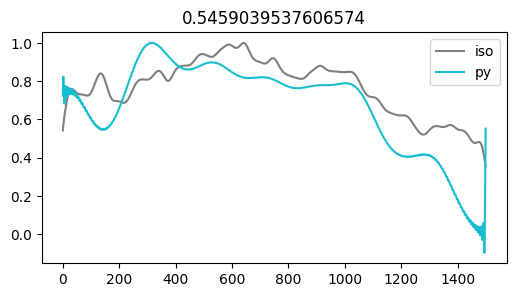

Resample both signals to a length of 1681 samples.
Discrete time shift of 227.
Resample both signals to a length of 1500 samples.


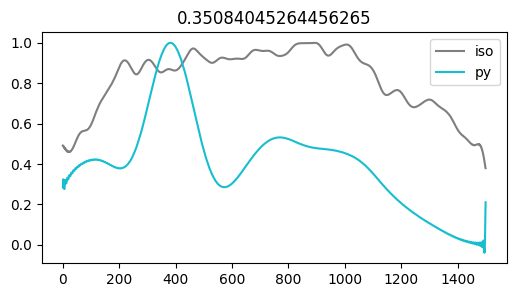

Resample both signals to a length of 1722 samples.
Discrete time shift of 186.
Resample both signals to a length of 1500 samples.


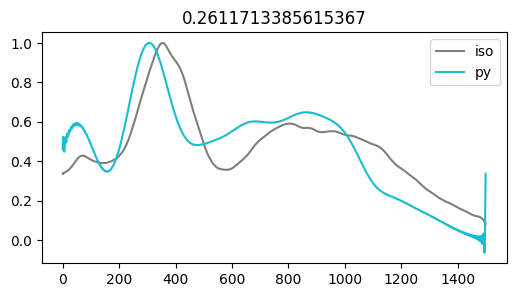

Resample both signals to a length of 1782 samples.
Discrete time shift of 38.
Resample both signals to a length of 1500 samples.


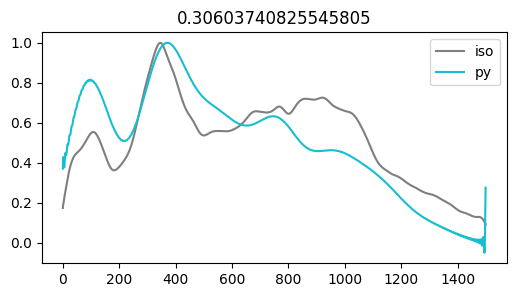

Resample both signals to a length of 1748 samples.
Discrete time shift of 66.
Resample both signals to a length of 1500 samples.


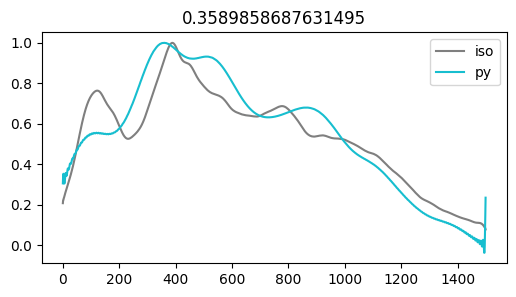

Resample both signals to a length of 1610 samples.
Discrete time shift of 102.
Resample both signals to a length of 1500 samples.


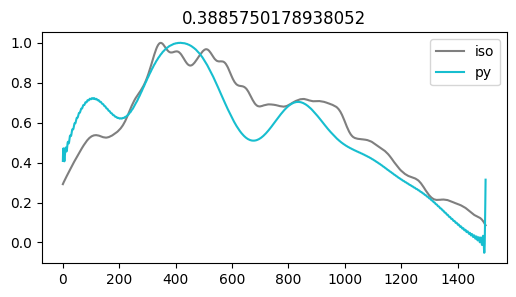

Resample both signals to a length of 1598 samples.
Discrete time shift of 80.
Resample both signals to a length of 1500 samples.


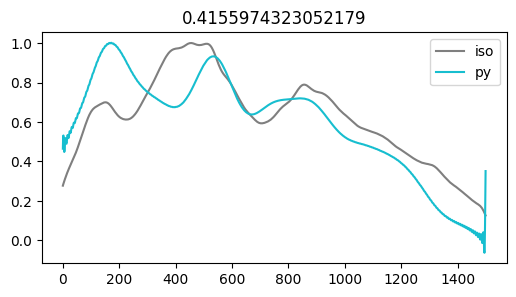

Resample both signals to a length of 1619 samples.
Discrete time shift of 111.
Resample both signals to a length of 1500 samples.


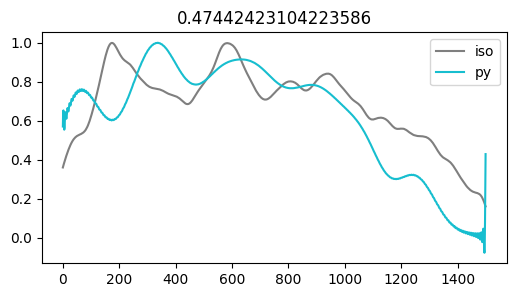

Resample both signals to a length of 1634 samples.
Discrete time shift of 115.
Resample both signals to a length of 1500 samples.


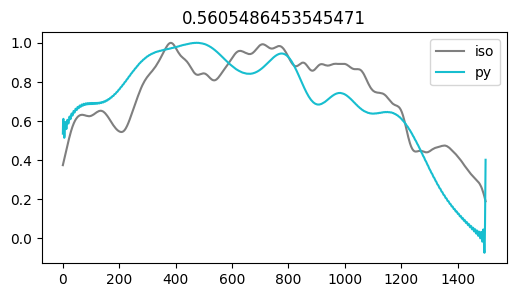

Resample both signals to a length of 1667 samples.
Discrete time shift of 173.
Resample both signals to a length of 1500 samples.


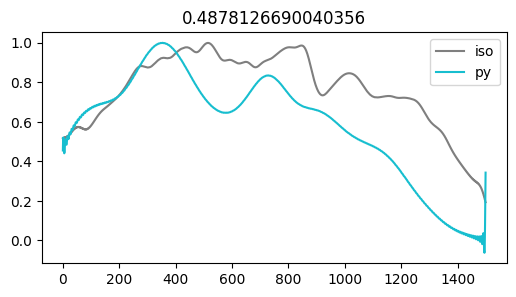

Resample both signals to a length of 1600 samples.
Discrete time shift of 98.
Resample both signals to a length of 1500 samples.


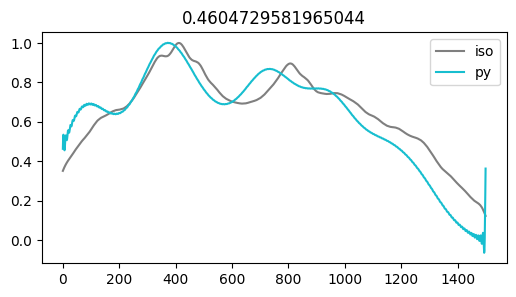

In [48]:
# Get the number of segments in each dictionary
num_iso_segments = len(isoforce_iso.torque_segments)
num_py_segments = len(isoforce_py.torque_segments)

# Remove the first segment from the dictionary with more elements
if num_iso_segments > num_py_segments:
    first_key_iso = next(iter(isoforce_iso.torque_segments))
    del isoforce_iso.torque_segments[first_key_iso]
elif num_py_segments > num_iso_segments:
    first_key_py = next(iter(isoforce_py.torque_segments))
    del isoforce_py.torque_segments[first_key_py]

# Now both dictionaries have equal number of segments
min_segments = min(len(isoforce_iso.torque_segments), len(isoforce_py.torque_segments))

# Process the segments
for idx in range(1, min_segments):
    # Scale the amplitude range to [0,1]
    iso_seg = scale_to_range(isoforce_iso.torque_segments[f"T_seg_{idx}"])
    py_seg = scale_to_range(isoforce_py.torque_segments[f"T_seg_{idx}"])

    # Create two signals of the same length and compute the phase shift
    iso_seg_corr, py_seg_corr = resample_signals(iso_seg, py_seg)
    shift = detect_shift(iso_seg_corr, py_seg_corr)

    # Resample the original, amplitude-scaled signals to a constant length
    iso_seg, py_seg = resample_signals(iso_seg[shift:], py_seg, target_length=1500)

    # Plot results
    plt.figure(figsize=(6, 3))
    plt.title(np.correlate(iso_seg, py_seg)[0] / len(iso_seg))
    plt.plot(iso_seg, "C7", label="iso")
    plt.plot(py_seg, "C9", label="py")
    plt.legend()
    plt.show()

In [49]:
for start, stop in zip(isoforce_py.start_idxs, isoforce_py.stop_idxs):
    print("from", isoforce_py.time[start], "to", isoforce_py.time[stop])
    print("Δt", isoforce_py.time[stop] - isoforce_py.time[start])

from 2025-02-19 13:25:35.010000 to 2025-02-19 13:25:39.160000
Δt 0:00:04.150000
from 2025-02-19 13:26:30.370000 to 2025-02-19 13:26:34.640000
Δt 0:00:04.270000
from 2025-02-19 13:27:22.740000 to 2025-02-19 13:27:26.720000
Δt 0:00:03.980000
from 2025-02-19 13:28:17.110000 to 2025-02-19 13:28:21.360000
Δt 0:00:04.250000
from 2025-02-19 13:29:17.190000 to 2025-02-19 13:29:21.520000
Δt 0:00:04.330000
from 2025-02-19 13:30:23.040000 to 2025-02-19 13:30:27.230000
Δt 0:00:04.190000
from 2025-02-19 13:31:16.850000 to 2025-02-19 13:31:20.710000
Δt 0:00:03.860000
from 2025-02-19 13:32:10.790000 to 2025-02-19 13:32:14.630000
Δt 0:00:03.840000
from 2025-02-19 13:33:03.340000 to 2025-02-19 13:33:07.400000
Δt 0:00:04.060000
from 2025-02-19 13:34:04.120000 to 2025-02-19 13:34:08.240000
Δt 0:00:04.120000
from 2025-02-19 13:35:01.320000 to 2025-02-19 13:35:05.460000
Δt 0:00:04.140000
from 2025-02-19 13:35:55.330000 to 2025-02-19 13:35:59.420000
Δt 0:00:04.090000
from 2025-02-19 13:36:50.420000 to 2025-

## EIT & Isoforce Analysis

In [50]:
# raw EIT data
import glob

EIT_path = file_path + "/eit_npz/"
EIT_files = glob.glob(f"{EIT_path}/setup_*.npz")  # Ensures correct file pattern

print(len(EIT_files))  # Check if files are found

30030


In [51]:
file_path

'../measurements/P04'

In [52]:
eit = list()
eit_timestmps = list()

for ele in np.sort(EIT_files):
    tmp = np.load(ele, allow_pickle=True)
    eit.append(tmp["eit"])
    eit_timestmps.append(tmp["timestamp"])

eit = np.array(eit)
eit_abs = np.abs(eit)
time_stmp = np.array(eit_timestmps)

### check the timestamps between EIT and isoforce recorded by NI

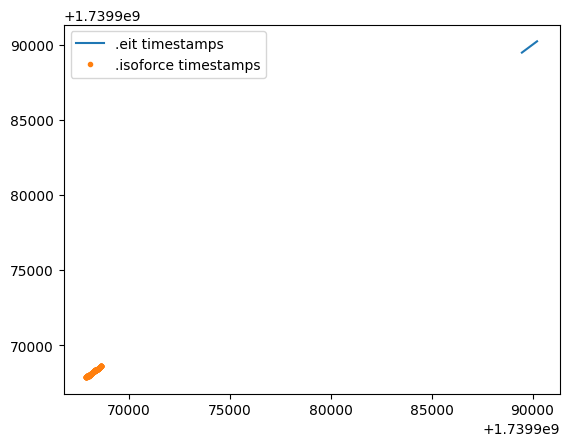

In [53]:
# Raw Isoforce
iso_timestmps = isoforce_py.timestmp_current

plt.plot(eit_timestmps, eit_timestmps, "-", label=".eit timestamps")
plt.plot(iso_timestmps, iso_timestmps, ".", label=".isoforce timestamps")
plt.legend()
plt.show()

### PCA Analysis

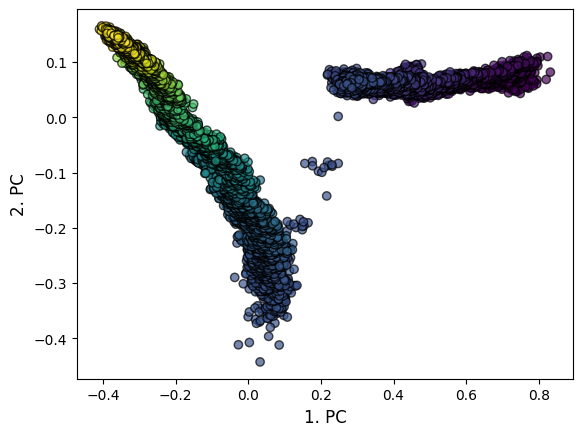

In [37]:
from sklearn.decomposition import PCA

data_flattened = eit_abs.reshape(eit_abs.shape[0], -1)
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(data_flattened)

plt.scatter(
    data_reduced[:, 0],
    data_reduced[:, 1],
    c=scale_to_range(eit_timestmps),
    edgecolors="k",
    alpha=0.7,
)
plt.xlabel("1. PC", fontsize=12)
plt.ylabel("2. PC", fontsize=12)
plt.show()

# Corresponding EIT values

In [38]:
EIT_segments = list()
isoforce_unix_time = np.array([t.timestamp() for t in isoforce_py.time])

for start, stop in zip(isoforce_py.start_idxs, isoforce_py.stop_idxs):
    start_time = isoforce_unix_time[start]
    stop_time = isoforce_unix_time[stop]

    # Find closest indices in EIT time array
    start_idx = np.argmin(np.abs(eit_timestmps - start_time))
    stop_idx = np.argmin(np.abs(eit_timestmps - stop_time))
    EIT_segments.append(eit_abs[start_idx : stop_idx + 1, :, :])